In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
from VerletSolver import VerletSolver as VS
from Vector import Vector as Vec
import matplotlib.patches as mpatches


In [2]:
'''Planet Class'''

class Planet():
    from Vector import Vector as Vec
    def __init__(self, name="Planet X", mass=1, position=Vec(), velocity=Vec(), radius=1,color='black'):
        '''Takes in name of the planet, its mass/mass of the sun, and the position and velocity vectors'''
        self.mass = mass
        self.name = name
        self.position = position
        self.x = position.x
        self.y = position.y
        self.z = position.z
        self.pos_lst = [self.x, self.y, self.z]
        self.velocity = velocity
        self.vx = 365*velocity.x
        self.vy = 365*velocity.y
        self.vz = 365*velocity.z
        self.vel_lst = [self.vx, self.vy, self.vz]
        self.r = position.magnitude()
        self.v_mag = velocity.magnitude()
        self.radius = radius
        self.color = color
        
    def __str__(self):
        return self.name

    
    def grav_accel(self, other_planet, i):
        #difference = self.coordinates[coord_index]-other_planet.coordinates[coord_index]
        return -4*math.pi*self.mass*(self.pos_lst[i] - other_planet.pos_lst[i])/((self.position.distance(other_planet))**3)
    
    def distance(self, other_planet):
        return ((self.x-other_planet.x)**2 + (self.y-other_planet.y)**2 + (self.z-other_planet.z)**2)**(0.5)
    
    def kinetic_energy(self):
        return .5*self.mass*self.v_mag**2
    
    def potential_energy(self):
        try:
            return -4*math.pi**2*self.mass/self.r
        except ZeroDivisionError:
            return 0

    def angular_momentum(self):
        return self.mass*self.r*self.v_mag
    
    

In [3]:
'''Solar System Class'''

class SolarSystem:
    def __init__(self, iters = 365):
        self.planets = {}
        self.iters = iters
        
    def add_planet(self, planet, x=0, y=0, z=0, vx=0, vy=0, vz=0):
        x_, y_, z_, vx_, vy_, vz_ = np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters)
        ke, pe, te, l = np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters), np.zeros(self.iters)
        x_[0] = x
        y_[0] = y
        z_[0] = z
        vx_[0] = vx
        vy_[0] = vy
        vz_[0] = vz
        ke[0] = planet.kinetic_energy()
        pe[0] = planet.potential_energy()
        te[0] = ke[0] + pe[0]
        l[0] = planet.angular_momentum()
        self.planets[planet] = [x_,y_,z_,vx_,vy_,vz_,ke,pe,te,l]
    def __str__(self):
        return_string = "|---BODY---|---MASS---|---X---|---Y---|---Z---|"
        return_string += "\n"

        for p in self.planets:
            return_string += "{:12}{:.6f}  {:.6f} {:.6f} {:.6f}".format(p.name,p.mass,p.x,p.y,p.z)
            return_string += "\n"
        return return_string
            

In [17]:
'''Define Functions'''

def kinetic_energy(mass,velocity):
    return .5*mass*velocity**2

def potential_energy(m1, m2, r):
    try:
        return -4*math.pi**2*m1*m2/r
    except ZeroDivisionError:
        return 0

def angular_momentum(m, v, r):
    return m*v*r

def algo(c_i, v_i, r, h):
    a_i = VS.acceleration(c_i, r)
    c_i_1 = VS.coordinate(c_i, h, v_i, a_i)
    a_i_1 = VS.acceleration(c_i_1, r)
    v_i_1 = VS.velocity(v_i, h, a_i_1, a_i)
    return c_i_1, v_i_1, a_i_1


def iterate(SS):
    for i in range(SS.iters-1):
        '''iteration over time steps loop'''
        for p in SS.planets:
            '''planets loop'''
            arrs = SS.planets[p]
            p_lst = []
            v_lst = []
            for j in range(3):
                '''component loop: j = 0 => x & vx; j = 1 => y & vy; j = 2 => z & vz'''
                
                try:
                    c_i = arrs[j][i]
                    v_i = arrs[j+3][i]
                    c_i_1, v_i_1, a_i_1 = algo(c_i, v_i, p.r, h)
                    arrs[j][i+1], arrs[j+3][i+1] = c_i_1, v_i_1
                    p_lst.append(c_i_1)
                    v_lst.append(v_i_1)
                    
                except ZeroDivisionError:
                    p_lst.append(0)
                    v_lst.append(0)
                
            p_vec = Vec(p_lst[0],p_lst[1],p_lst[2])
            v_vec = Vec(v_lst[0],v_lst[1],v_lst[2])
            ke = kinetic_energy(p.mass, v_vec.magnitude())
            pe = potential_energy(p.mass, 1, p_vec.magnitude())
            te = ke + pe
            l = angular_momentum(p.mass, v_vec.magnitude(), p_vec.magnitude())
            arrs[6][i+1], arrs[7][i+1], arrs[8][i+1], arrs[9][i+1] = ke, pe, te, l

def iterate_with_interactions(SS):
    for i in range(SS.iters-1):
        '''iteration over time steps loop'''
        for p in SS.planets:
            '''planets loop'''
            arrs = SS.planets[p]
            p_lst = []
            v_lst = []
            for j in range(3):
                '''component loop: j = 0 => x & vx; j = 1 => y & vy; j = 2 => z & vz'''
                
                try:
                    c_i = arrs[j][i]
                    v_i = arrs[j+3][i]
                    a_i = VS.acceleration(c_i, p.r)
                    for q in SS.planets:
                        if p != q:
                            a_i += p.grav_accel(q, j)
                    c_i_1, v_i_1, a_i_1 = algo(c_i, v_i, p.r, h)
                    arrs[j][i+1], arrs[j+3][i+1] = c_i_1, v_i_1
                    p_lst.append(c_i_1)
                    v_lst.append(v_i_1)
                    
                except ZeroDivisionError:
                    p_lst.append(0)
                    v_lst.append(0)
                
            p_vec = Vec(p_lst[0],p_lst[1],p_lst[2])
            v_vec = Vec(v_lst[0],v_lst[1],v_lst[2])
            ke = kinetic_energy(p.mass, v_vec.magnitude())
            pe = potential_energy(p.mass, 1, p_vec.magnitude())
            te = ke + pe
            l = angular_momentum(p.mass, v_vec.magnitude(), p_vec.magnitude())
            arrs[6][i+1], arrs[7][i+1], arrs[8][i+1], arrs[9][i+1] = ke, pe, te, l
                
                
def plot_3D(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x,y,z,s=5)

    ax.set_xlabel('AU x-axis')
    ax.set_ylabel('AU y-axis')
    ax.set_zlabel('Au z-axis')
    
def plot_3D_pos(dic):
    fig = plt.figure(figsize=(40,22.5))
    ax = fig.add_subplot(111, projection='3d')

    for p in dic:
        ax.plot(xs=dic[p][0],ys=dic[p][1], zs = dic[p][2], c = p.color)
        ax.scatter(xs=dic[p][0][-1],ys=dic[p][1][-1], zs = dic[p][2][-1], s = p.radius*20000, c = p.color)
    ax.set_title('The Solar System')

    ax.set_xlabel('AU x-axis')
    ax.set_ylabel('AU y-axis')
    ax.set_zlabel('AU z-axis')
    
def plot_energies(ke,pe,te,x):
    red_patch = mpatches.Patch(color='red', label='Kinetic Energy')
    blue_patch = mpatches.Patch(color='blue', label='Potential Energy')
    green_patch = mpatches.Patch(color='green', label='Total Energy')

    plt.legend(handles=[red_patch, blue_patch, green_patch],loc=7)
    plt.xlim(0,max(x))
    plt.ylim(min(pe),max(ke)+.1*max(ke))
    plt.xlabel('years')
    plt.ylabel('energy')
    plt.plot(x,ke,color='red')
    plt.plot(x,pe,color='blue')
    plt.plot(x,te,color='green')

In [21]:
'''Initialize'''
r_sun = .0046491304 #au
sun = Planet("Sun", 1.00, Vec(3.164698112995927E-03,4.430714289164239E-03,-1.514470525690960E-04),Vec(-3.379874197009493E-06,6.606862110289219E-06,7.322972380061941E-08), radius = r_sun, color='orange')
sun = Planet("Sun", 1.00, Vec(0.0,0.0,0.0),Vec(-3.379874197009493E-06,6.606862110289219E-06,7.322972380061941E-08), radius = r_sun, color='orange')

mercury = Planet("Mercury",1.65E-07,Vec(2.80E-01,1.73E-01,-1.18E-02),Vec(-2.01E-02,2.53E-02,3.91E-03), color='gray', radius=0.035073*r_sun)
venus = Planet("Venus", 2.45E-06, Vec(-7.02E-02, 1.36E-01, 4.24E-02), Vec(-3.81E-03, -1.99E-02, -5.40E-05), color = 'yellow',radius=0.008699*r_sun)
earth = Planet("Earth", 3.0E-06, Vec(-9.882510901700633E-01, 8.499778853173919E-02, -1.519972828171497E-04),
              Vec(-1.680240369278054E-03, -1.719988462359221E-02, 4.349840395398017E-07), radius = 0.0009167*r_sun, color='blue')
mars = Planet("Mars", 3.3E-07, Vec(7.78E-01, 1.28, 7.56E-03), Vec(-1.14E-02, 8.47E-03, 4.58E-04), color='red', radius = 0.0048728*r_sun)
jupiter = Planet('Jupiter', 0.00095, Vec(-5.23, -1.53, 1.23E-01),Vec(2.02E-3, -6.88E-03, -1.67E-05), radius = r_sun*0.10049, color='orange')
saturn = Planet("Saturn", 0.000275, Vec(-1.48,-9.93, 2.32E-01), Vec(5.212E-03, -8.39E-04, -1.93E-04),color='yellow', radius = r_sun*0.083703)
uranus = Planet("Uranus", 0.000044, Vec(1.82E01, 8.08, -2.06E-01), Vec(-1.62E-03, 3.41E-03, 3.38E-05), color = 'cyan', radius = r_sun*0.036455)
neptune = Planet("Neptune", 0.0000515, Vec(2.84E01, -9.47, -4.60E-01),Vec(9.711E-04, 2.997E-03, -8.38E-05), color='blue', radius = r_sun*0.0353917)
pluto = Planet("Pluto", 6.55E-09, Vec(9.89, -3.18E01, 5.396E-01), Vec(3.06E-03, 2.906E-04, -9.09E-04), color='gray', radius = r_sun*0.001706)
planets = [sun, mercury, earth, mars, jupiter, saturn, uranus, neptune, pluto]


Project 3b): Writing an object oriented code for the Earth-Sun system.

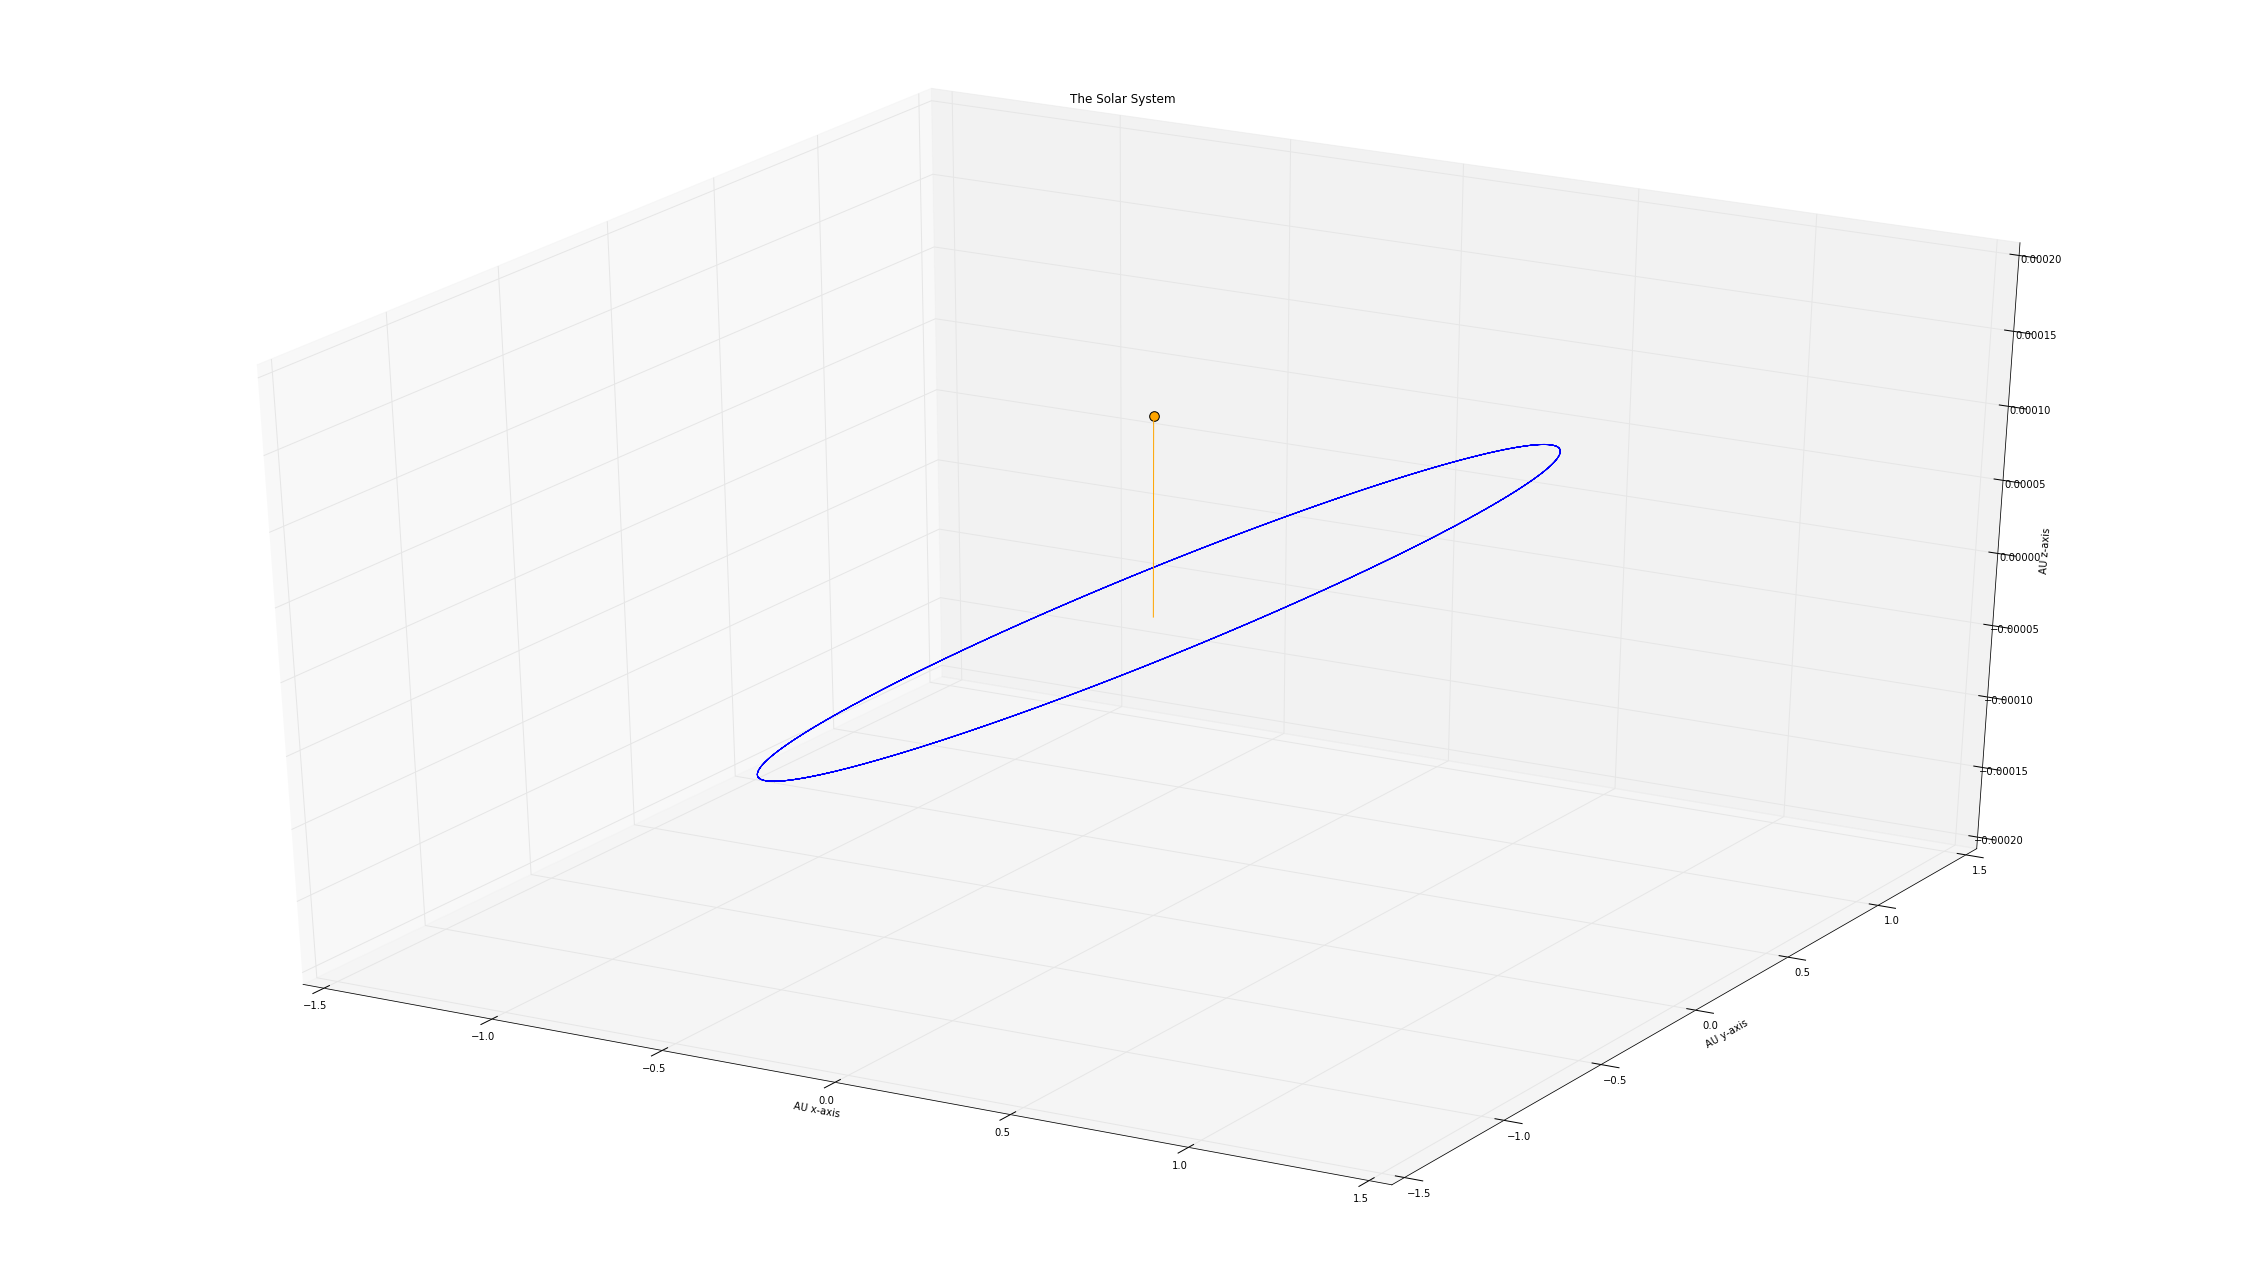

In [22]:
'''One Planet'''
'''First plot position'''
years = 5
planets = [sun, earth]
h = 1/365
n = int(years/h)
SS = SolarSystem(iters=n)
for p in planets:
    SS.add_planet(p, p.x, p.y, p.z, p.vx, p.vy, p.vz)

iterate(SS)
plot_3D_pos(SS.planets)

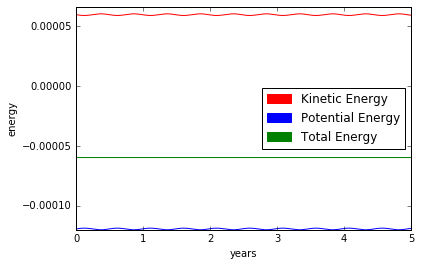

In [23]:
'''Earth Energy plot'''
plot_energies(SS.planets[earth][6], SS.planets[earth][7], SS.planets[earth][8], np.linspace(0,5,n))

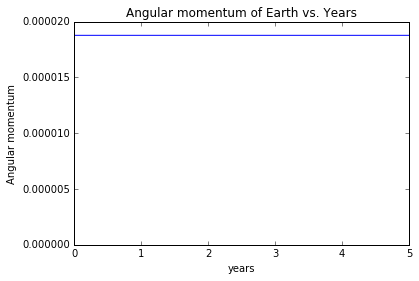

In [24]:
'''Earth Angular Momentum'''
plt.plot(np.linspace(0,5,n),SS.planets[earth][9])
plt.title("Angular momentum of Earth vs. Years")
plt.xlabel("years")
plt.ylabel("Angular momentum")

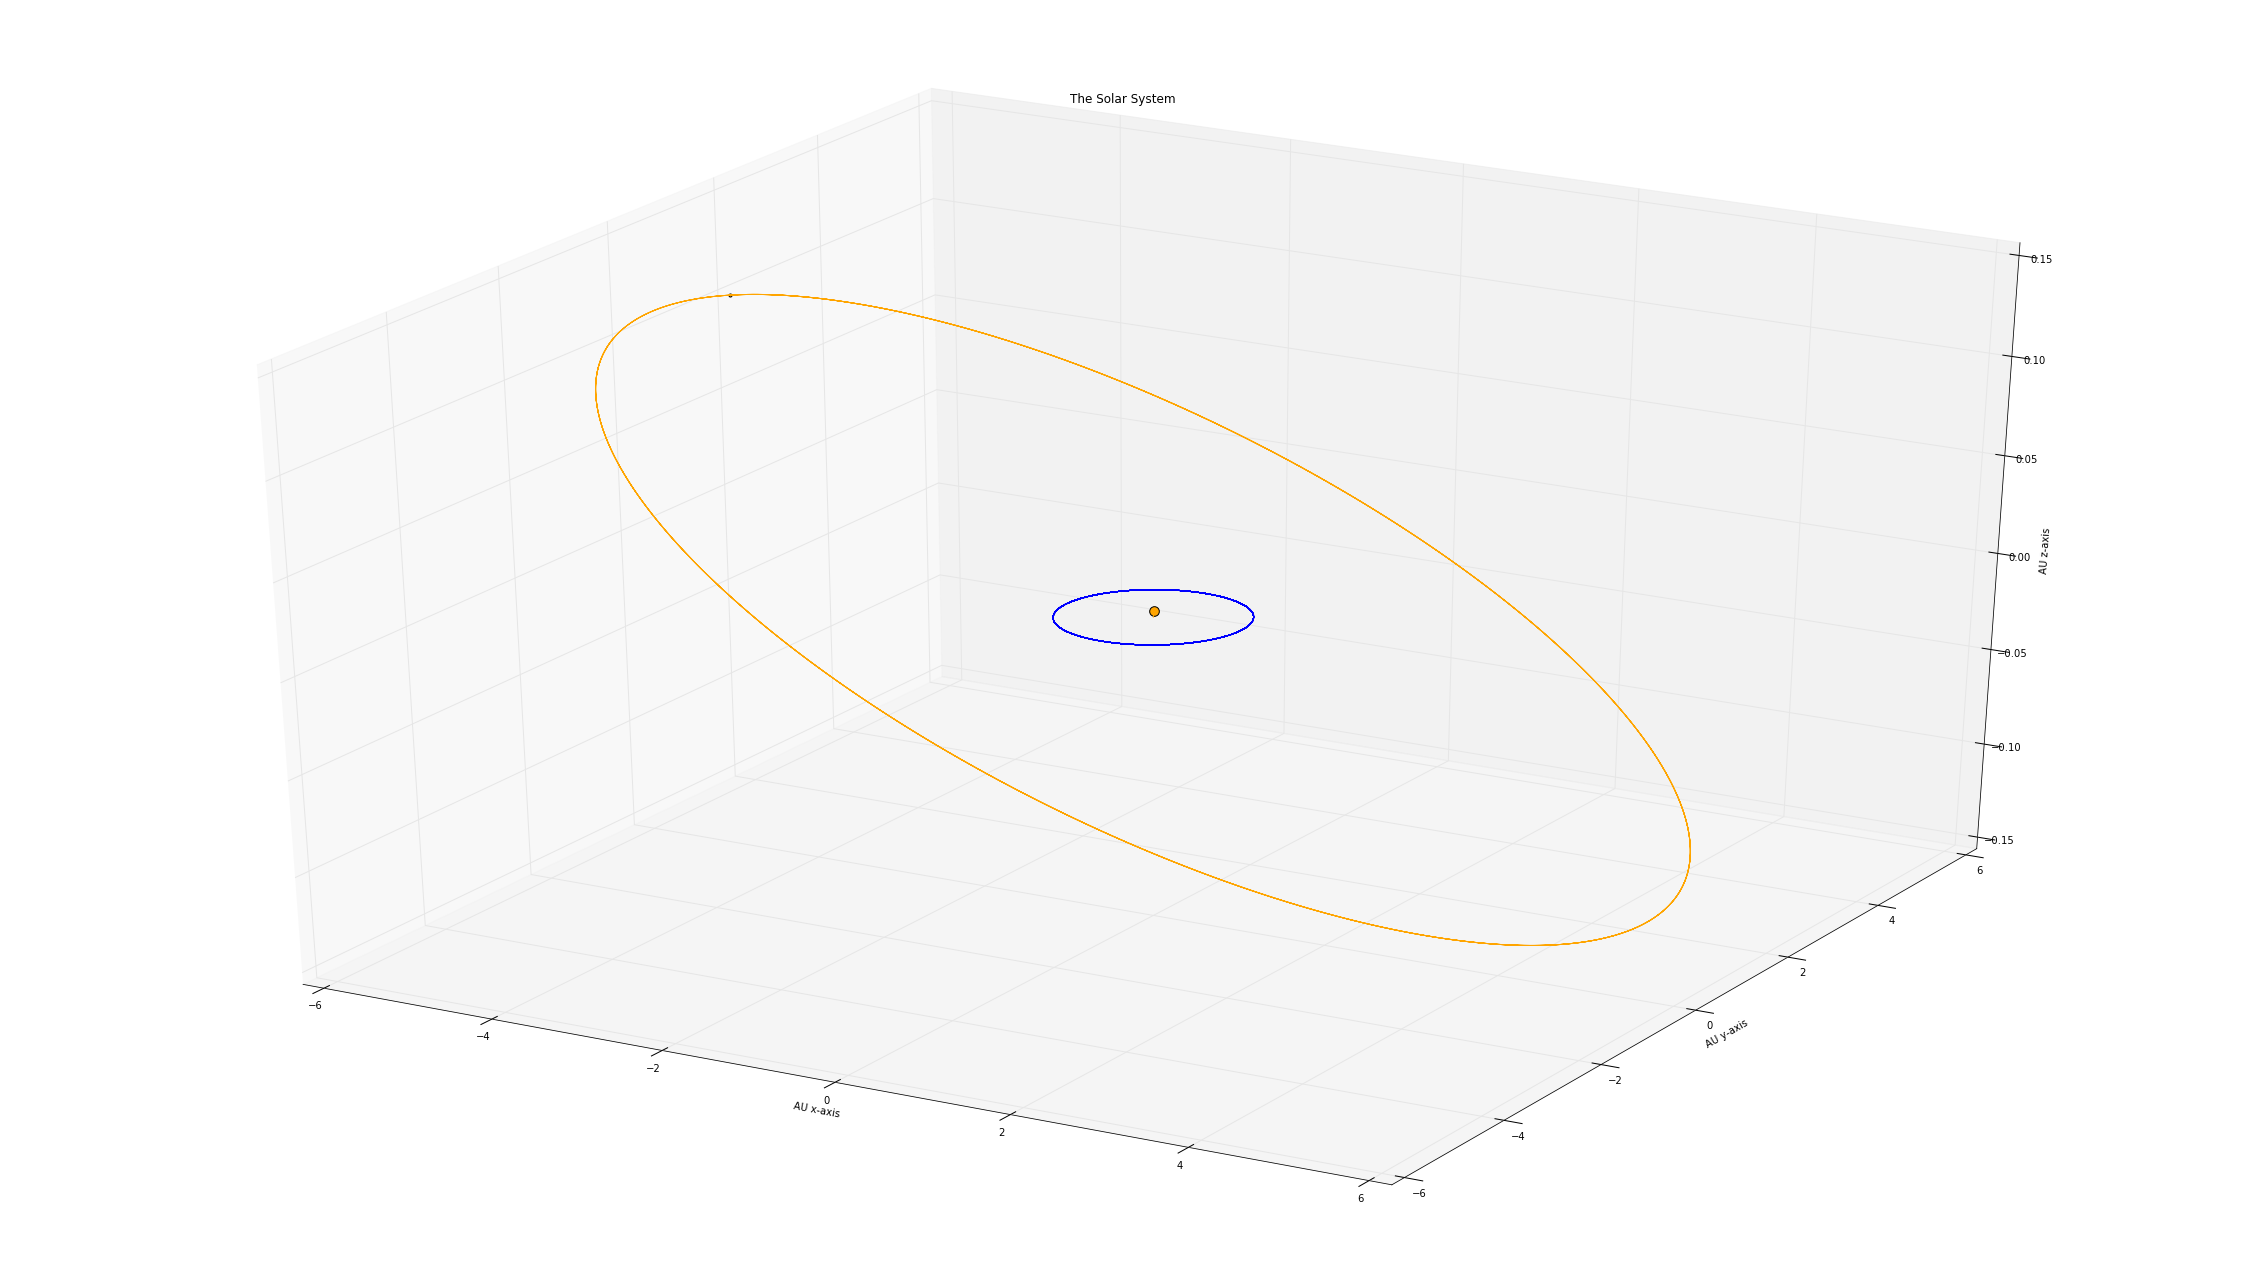

In [25]:
'''Sun with Earth vs. Jupter interactions'''
planets = [sun, earth, jupiter]

years = 50
h = 1/365
n = int(years/h)
SS = SolarSystem(iters=n)
for p in planets:
    SS.add_planet(p, p.x, p.y, p.z, p.vx, p.vy, p.vz)
iterate_with_interactions(SS)
plot_3D_pos(SS.planets)


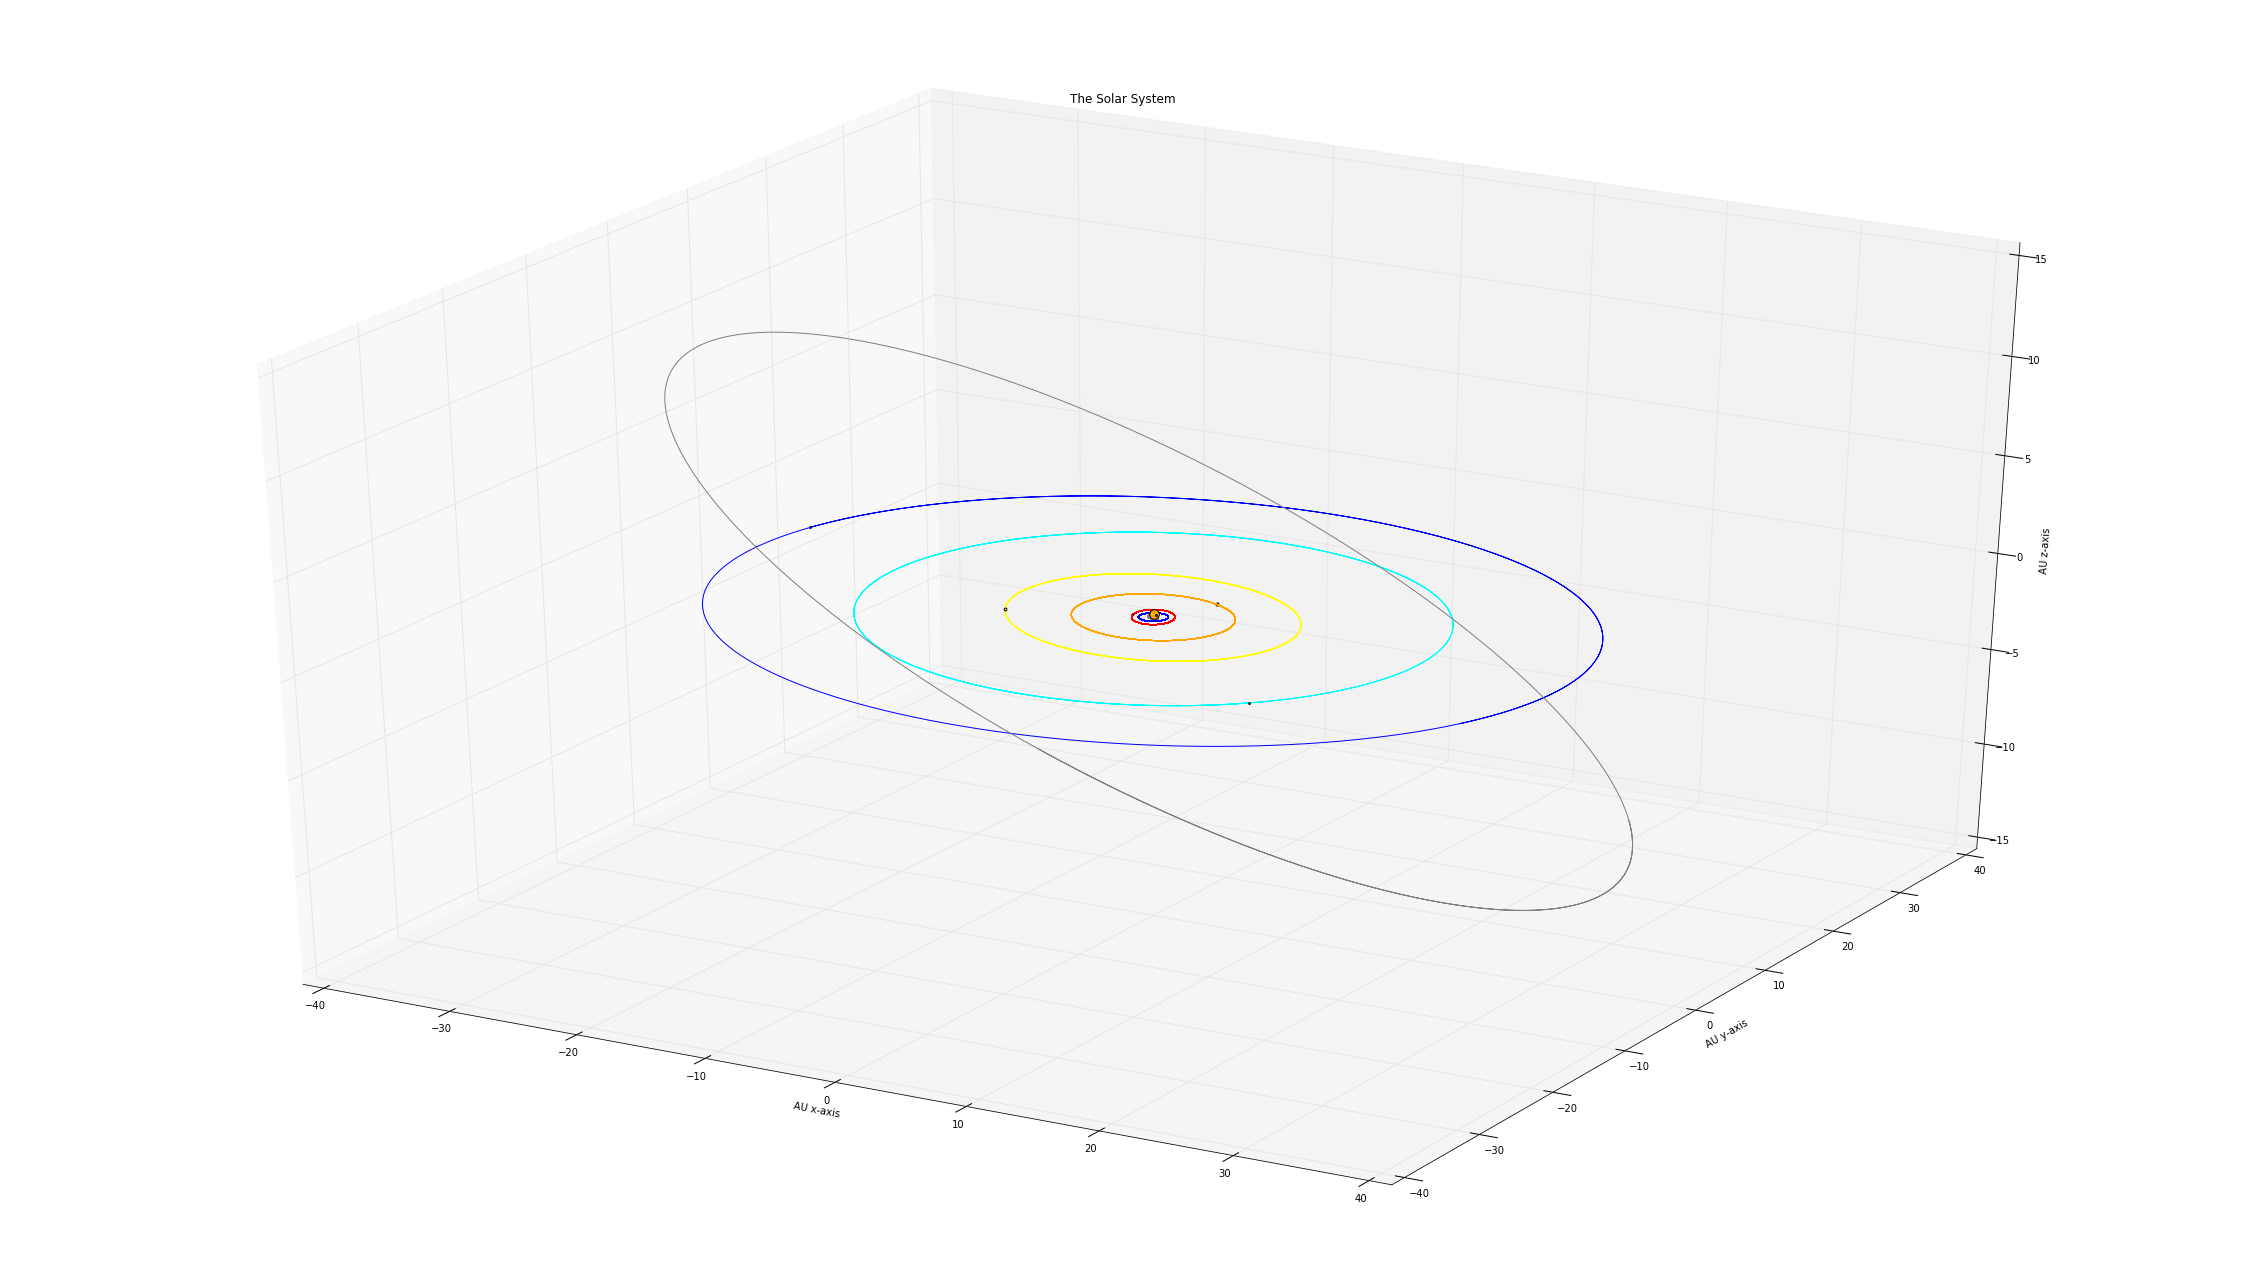

In [26]:
'''The entire solar system without interactions'''

planets = [sun, mercury, earth, mars, jupiter, saturn, uranus, neptune, pluto]

years = 250
h = 1/365
n = int(years/h)
SS = SolarSystem(iters=n)
for p in planets:
    SS.add_planet(p, p.x, p.y, p.z, p.vx, p.vy, p.vz)
iterate(SS)
plot_3D_pos(SS.planets)

    

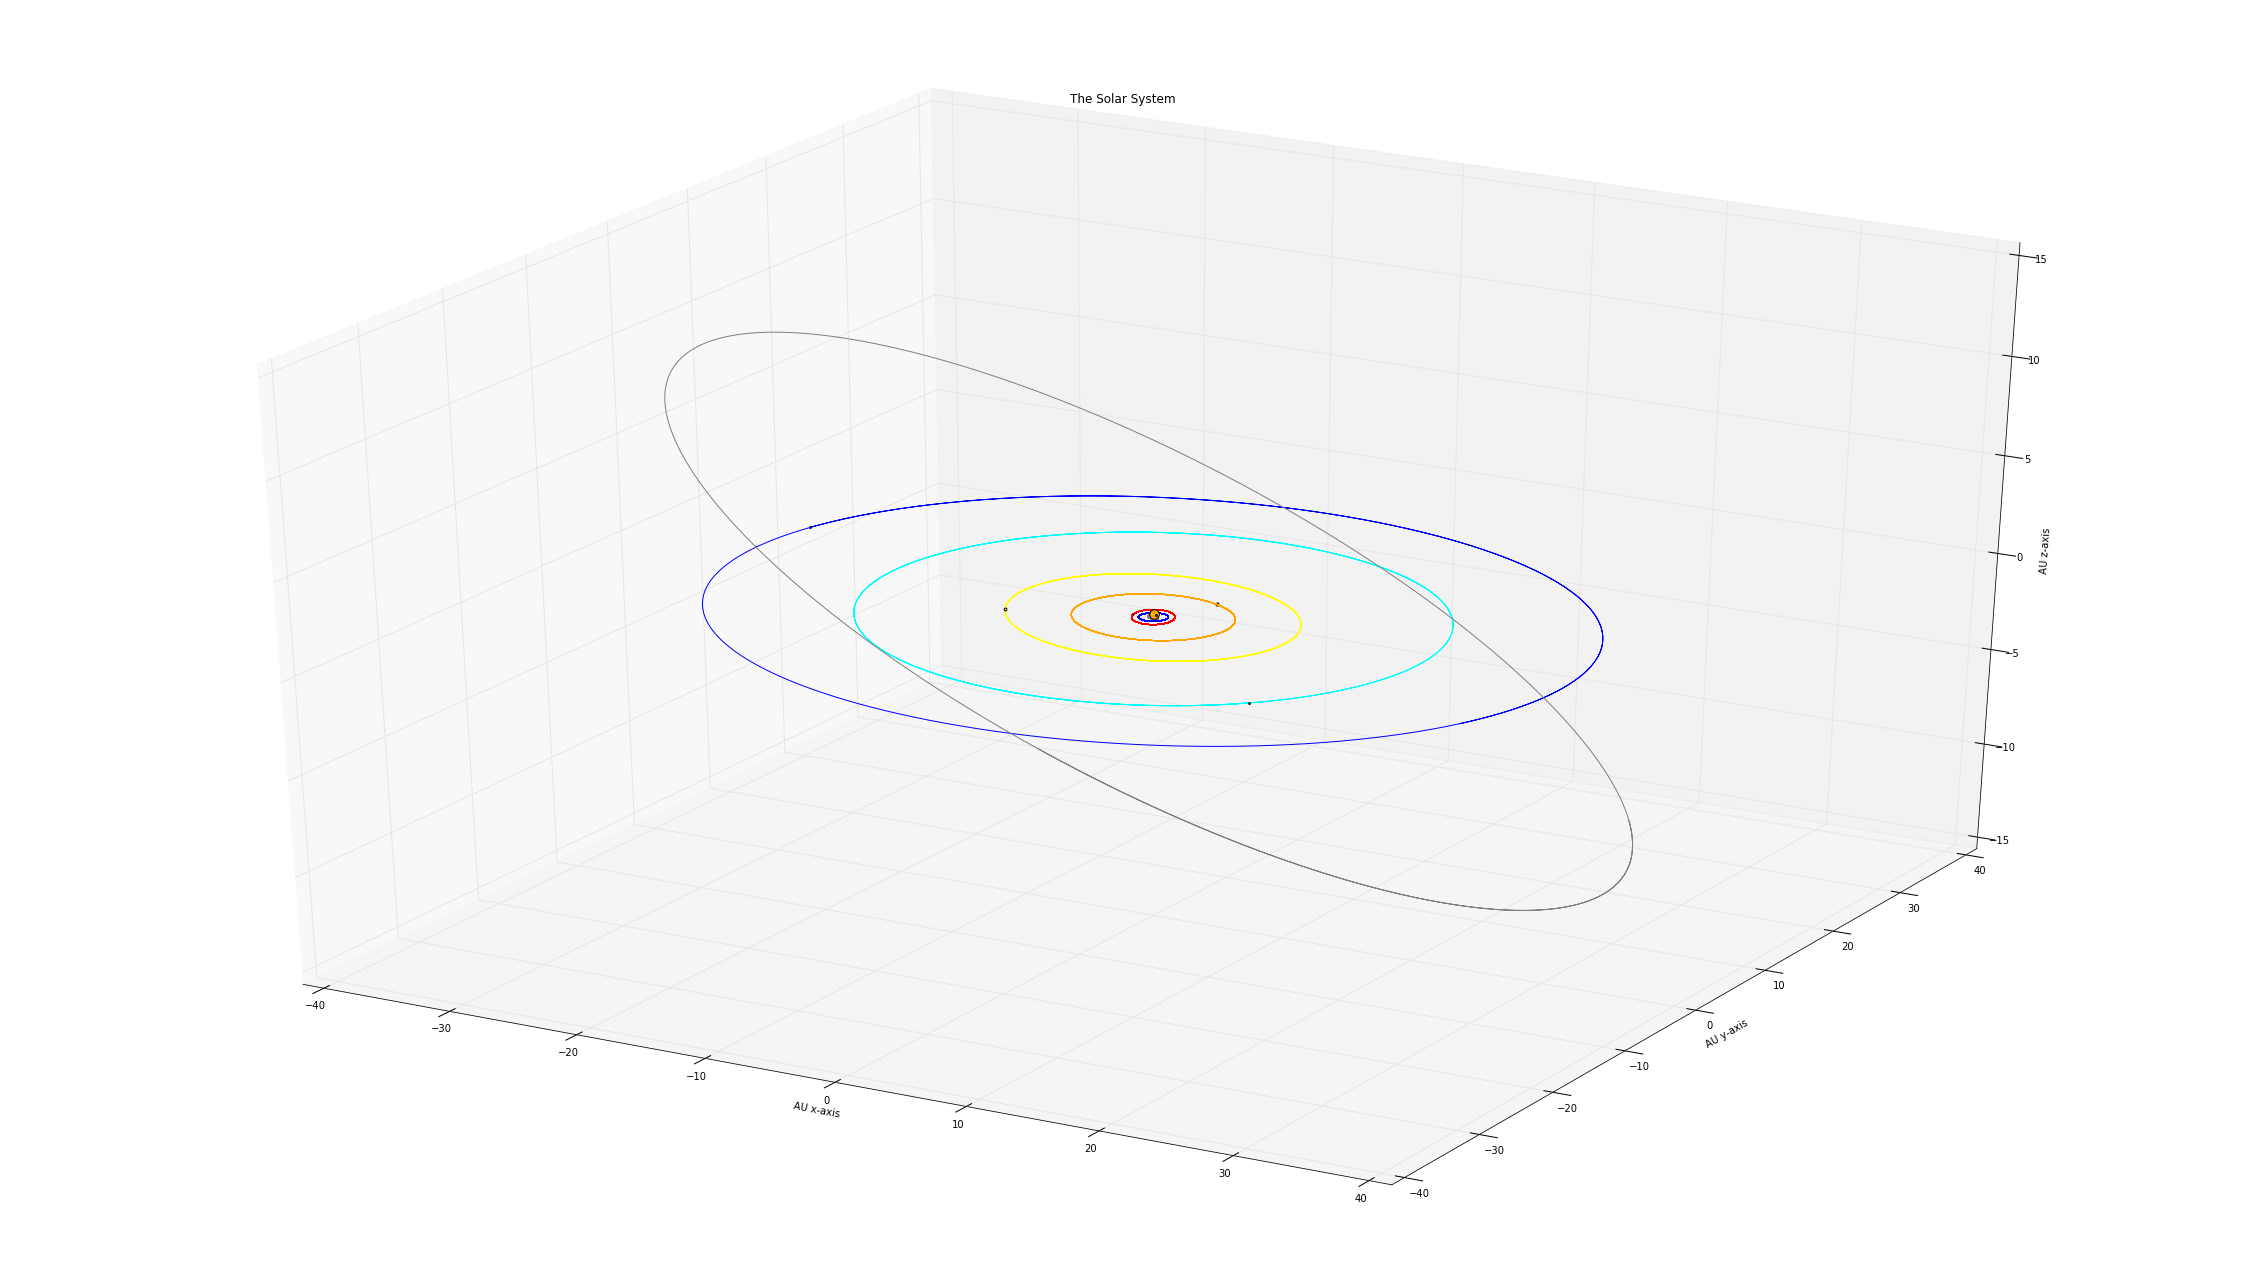

In [27]:
'''Solar System with interactions'''

planets = [sun, mercury, earth, mars, jupiter, saturn, uranus, neptune, pluto]

years = 250
h = 1/365
n = int(years/h)
SS = SolarSystem(iters=n)
for p in planets:
    SS.add_planet(p, p.x, p.y, p.z, p.vx, p.vy, p.vz)
iterate_with_interactions(SS)
plot_3D_pos(SS.planets)
